### GA4 데이터로 프로덕트 분석
- 출처: kaggle, Google Analytics Customer Revenue Prediction
https://www.kaggle.com/competitions/ga-customer-revenue-prediction/data?select=train.csv


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import json

In [2]:
# 파일 불러오기
df_origin = pd.read_csv('D:/2024 내일배움캠프/phython/A06_team_project/train.csv', encoding='utf-8')
df_origin.info()

C:\Users\dkf22\AppData\Local\Temp\ipykernel_9544\959461698.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_origin = pd.read_csv('D:/2024 내일배움캠프/phython/A06_team_project/train.csv', encoding='utf-8')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       903653 non-null  object
 1   date                  903653 non-null  int64 
 2   device                903653 non-null  object
 3   fullVisitorId         903653 non-null  object
 4   geoNetwork            903653 non-null  object
 5   sessionId             903653 non-null  object
 6   socialEngagementType  903653 non-null  object
 7   totals                903653 non-null  object
 8   trafficSource         903653 non-null  object
 9   visitId               903653 non-null  int64 
 10  visitNumber           903653 non-null  int64 
 11  visitStartTime        903653 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 82.7+ MB


In [3]:
# 딕셔너리 모양 문자열 칼럼을 데이터프레임으로 펼치기 
def get_columns(columns_list: list):
    """" 딕셔너리 모양으로 들어간 문자열 칼럼을 데이터 프레임으로 변환해주는 함수  
    Args:
        columns_list(list): df_origin(pd.DataFrame)에서 변환이 필요한 칼럼명 리스트 

    Returns:
        pd.DataFrame: 데이터프레임
    """""
    df = df_origin.copy()

    for col in columns_list:
        change_df = pd.json_normalize(json.loads(row) for row in list(df[col]))
        change_df.columns = [f'{col}.{subcol}' for subcol in change_df.columns]
        df = df.drop(col, axis=1)
        df = pd.concat([df, change_df], axis = 1)
    return df

json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
df = get_columns(json_columns)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

In [4]:
# 불필요한 칼럼 삭제(분석 칼럼 22개)
df = df[['channelGrouping','date','fullVisitorId', 'visitNumber',\
          'visitStartTime', 'device.isMobile','device.deviceCategory', 'geoNetwork.continent', \
          'geoNetwork.country', 'totals.visits','totals.hits', 'totals.pageviews', \
          'totals.bounces', 'totals.newVisits', 'totals.transactionRevenue', 'trafficSource.campaign',\
          'trafficSource.source', 'trafficSource.medium','trafficSource.keyword', 'trafficSource.isTrueDirect',\
          'trafficSource.adwordsClickInfo.slot','trafficSource.adwordsClickInfo.adNetworkType']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 22 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   channelGrouping                               903653 non-null  object
 1   date                                          903653 non-null  int64 
 2   fullVisitorId                                 903653 non-null  object
 3   visitNumber                                   903653 non-null  int64 
 4   visitStartTime                                903653 non-null  int64 
 5   device.isMobile                               903653 non-null  bool  
 6   device.deviceCategory                         903653 non-null  object
 7   geoNetwork.continent                          903653 non-null  object
 8   geoNetwork.country                            903653 non-null  object
 9   totals.visits                                 903653 non-nu

### 데이터 전처리


- 데이터 타입 변경

In [5]:
# 문자열로 변환: 'date','fullVisitorId','visitId','visitNumber','visitStartTime' 
df = df.astype({'date':'str', 'fullVisitorId':'str', 'visitNumber':'str'})

# 정수형으로 변환: 'totals.visits','totals.hits','totals.pageviews','totals.bounces','totals.newVisits','totals.transactionRevenue'
# astype으로 변경 시 'totals.pageviews'에서 에러(float NaN) 발생하여 to_numeric으로 조정 
numberic_list = ['totals.visits','totals.hits','totals.pageviews','totals.bounces','totals.newVisits','totals.transactionRevenue'] 

for num_col in numberic_list:
    df[num_col] = pd.to_numeric(df[num_col], errors='coerce') #coerce는 오류 발견시 NaN으로 변경

# totals_transactionRevenue 금액 조정 
# GA상 매출액 10^6 값으로 표기 (ex. 2.4는 2400000로)
df['totals.transactionRevenue'] = (df['totals.transactionRevenue']**(1/6)).round(2)

In [6]:
# datetime으로 변환: 'date' (str > int > datetime)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')

df.describe(include='all')

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.country,totals.visits,...,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.adNetworkType
count,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653.0,...,450630.0,703060.0,11515.000000,903653,903653,903653,400724,274005,21460,21460
unique,8,NaN,716924,384,NaN,2,3,6,222,NaN,...,NaN,NaN,NaN,10,380,7,3659,1,2,2
top,Organic Search,NaN,1957458976293878100,1,NaN,False,desktop,Americas,United States,NaN,...,NaN,NaN,NaN,(not set),google,organic,(not provided),True,Top,Google Search
freq,381561,NaN,278,703060,NaN,664530,664479,450377,364744,NaN,...,NaN,NaN,NaN,865347,400788,381561,366363,274005,20956,21453
mean,NaN,2017-01-20 18:54:58.635206400,NaN,NaN,2017-01-21 14:01:30.059528448,NaN,NaN,NaN,NaN,1.0,...,1.0,1.0,19.908796,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2016-08-01 00:00:00,NaN,NaN,2016-08-01 07:00:12,NaN,NaN,NaN,NaN,1.0,...,1.0,1.0,4.640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2016-10-27 00:00:00,NaN,NaN,2016-10-27 09:39:29,NaN,NaN,NaN,NaN,1.0,...,1.0,1.0,17.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2017-01-09 00:00:00,NaN,NaN,2017-01-09 08:02:14,NaN,NaN,NaN,NaN,1.0,...,1.0,1.0,19.160000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2017-04-21 00:00:00,NaN,NaN,2017-04-21 07:12:42,NaN,NaN,NaN,NaN,1.0,...,1.0,1.0,21.810000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2017-08-01 00:00:00,NaN,NaN,2017-08-02 06:59:53,NaN,NaN,NaN,NaN,1.0,...,1.0,1.0,53.380000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 결측치 처리

In [7]:
# 결측치는 0 값으로 대치  
# 대상 칼럼: 'totals.newVisits', 'totals.transactionRevenue'
# 매출 값은 구매 여부를 확인할 수 있도록 신규 열 생성 

def get_binary(x: int) -> int:
    """
    값이 0보다 크면 1, 0이거나 그보다 작으면 0을 반환하는 함수

    Args:
        x (int): 변환할 데이터 값으로 이외의 데이터 타입이 올 수 있음
    Returns:
        int: 값이 0보다 크면 1, 0이거나 그보다 작으면 0을 반환
    """
    if x > 0:
        return 1
    else:
        return 0

df['Revenue_yn'] = df['totals.transactionRevenue'].apply(get_binary)
df['newVisits_yn'] = df['totals.newVisits'].apply(get_binary)
display(df['Revenue_yn'].value_counts())
display(df['newVisits_yn'].value_counts())

Revenue_yn
0    892138
1     11515
Name: count, dtype: int64

newVisits_yn
1    703060
0    200593
Name: count, dtype: int64

- 인코딩(수기)

In [8]:
def get_binary(x: str) -> int:
    """
    캠페인명이 있으면 1, (not set)이면 0을 반환하는 함수

    Args:
        x (str): 변환할 데이터 값으로 이외의 데이터 타입이 올 수 있음
    Returns:
        int: 캠페인명이 있으면 1, (not set)이면 0을 반환
    """
    if x == '(not set)':
        return 0
    else:
        return 1

df['campaign_yn'] = df['trafficSource.campaign'].apply(get_binary)
display(df['campaign_yn'].value_counts())

campaign_yn
0    865347
1     38306
Name: count, dtype: int64

- 인코딩 및 스케일링

In [9]:
# 라벨 인코더(범주형): channelGrouping, device.deviceCategory, geoNetwork.country
# 스케일링 (수치형): totals.pageviews, totals.visits, totals.hits (기타 - 평균 세션 시간, 재방문 수 등)

from sklearn.preprocessing import LabelEncoder, StandardScaler

en_lb = LabelEncoder()
# 0: (Other) 1: Affiliates 2: Direct 3: Display 4: Organic Search 5: Paid Search, 6: Referral, 7: Social
df['channel_en'] = en_lb.fit_transform(df[['channelGrouping']])
# 0: desktop 1: mobile 2: tablet
df['deviceCategory_en'] = en_lb.fit_transform(df[['device.deviceCategory']])
# 0: (not set) 1: Africa 2: Americas 3: Asia 4: Europe 5: Oceania
df['continent_en'] = en_lb.fit_transform(df[['geoNetwork.continent']])


sc_sd = StandardScaler()
df['pageviews_sc'] = sc_sd.fit_transform(df[['totals.pageviews']])
df['visits_sc'] = sc_sd.fit_transform(df[['totals.visits']])
df['hits_sc'] = sc_sd.fit_transform(df[['totals.hits']])

df.describe(include='all')

c:\Users\dkf22\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\dkf22\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\dkf22\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.country,totals.visits,...,trafficSource.adwordsClickInfo.adNetworkType,Revenue_yn,newVisits_yn,campaign_yn,channel_en,deviceCategory_en,continent_en,pageviews_sc,visits_sc,hits_sc
count,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653.0,...,21460,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,903653.000000,9.035530e+05,903653.0,9.036530e+05
unique,8,NaN,716924,384,NaN,2,3,6,222,NaN,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Organic Search,NaN,1957458976293878100,1,NaN,False,desktop,Americas,United States,NaN,...,Google Search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,381561,NaN,278,703060,NaN,664530,664479,450377,364744,NaN,...,21453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2017-01-20 18:54:58.635206400,NaN,NaN,2017-01-21 14:01:30.059528448,NaN,NaN,NaN,NaN,1.0,...,NaN,0.012743,0.778020,0.042390,4.632267,0.298370,2.716869,7.454953e-17,0.0,2.956490e-17
min,NaN,2016-08-01 00:00:00,NaN,NaN,2016-08-01 07:00:12,NaN,NaN,NaN,NaN,1.0,...,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.056448e-01,0.0,-3.730294e-01
25%,NaN,2016-10-27 00:00:00,NaN,NaN,2016-10-27 09:39:29,NaN,NaN,NaN,NaN,1.0,...,NaN,0.000000,1.000000,0.000000,4.000000,0.000000,2.000000,-4.056448e-01,0.0,-3.730294e-01
50%,NaN,2017-01-09 00:00:00,NaN,NaN,2017-01-09 08:02:14,NaN,NaN,NaN,NaN,1.0,...,NaN,0.000000,1.000000,0.000000,4.000000,0.000000,2.000000,-4.056448e-01,0.0,-2.693104e-01
75%,NaN,2017-04-21 00:00:00,NaN,NaN,2017-04-21 07:12:42,NaN,NaN,NaN,NaN,1.0,...,NaN,0.000000,1.000000,0.000000,7.000000,1.000000,3.000000,2.138506e-02,0.0,-6.187231e-02
max,NaN,2017-08-01 00:00:00,NaN,NaN,2017-08-02 06:59:53,NaN,NaN,NaN,NaN,1.0,...,NaN,1.000000,1.000000,1.000000,7.000000,2.000000,5.000000,6.621101e+01,0.0,5.138277e+01


데이터 분리
- 전처리(결측치, 인코딩) > 분리 > 스케일링 순으로 해도 되는지 확인 필요

In [10]:
from sklearn.model_selection import train_test_split

# 데이터를 train, test로 분리
X = df.drop(columns = ['Revenue_yn'])
y = df[['Revenue_yn']]

# 학습과 평가를 위해 데이터 셋 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state= 42)

#분리된 데이터 차원 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(677739, 30) (225914, 30) (677739, 1) (225914, 1)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 31 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   channelGrouping                               903653 non-null  object        
 1   date                                          903653 non-null  datetime64[ns]
 2   fullVisitorId                                 903653 non-null  object        
 3   visitNumber                                   903653 non-null  object        
 4   visitStartTime                                903653 non-null  datetime64[ns]
 5   device.isMobile                               903653 non-null  bool          
 6   device.deviceCategory                         903653 non-null  object        
 7   geoNetwork.continent                          903653 non-null  object        
 8   geoNetwork.country                            903653 n

### EDA

In [12]:
# pairplot_df = df[['channelGrouping','device.deviceCategory', 'geoNetwork.continent', \
#           'totals.visits','totals.hits', 'totals.pageviews', \
#           'newVisits_yn','campaign_yn','Revenue_yn']]

In [13]:
# sns.pairplot(pairplot_df)

- 월별 방문자 수 및 구매 수, 전환율 추이

In [ ]:
# 날짜데이터 정리 

import datetime as dt 

visit_year = df['visitStartTime'].dt.year
visit_month = df['visitStartTime'].dt.month
visit_ym = df['visitStartTime'].dt.strftime('%Y-%m')
visit_ymd = df['visitStartTime'].dt.strftime('%Y-%m-%d')
visit_day = df['visitStartTime'].dt.day
visit_day = df['visitStartTime'].dt.day
visit_dayofweek = df['visitStartTime'].dt.weekday # 월요일이 0 
visit_week = df['visitStartTime'].dt.strftime('%Y-%W') #몇번째주차인지


# 날짜별로 유저수, 구매수 확인 
main_variable = ['fullVisitorId', 'totals.transactionRevenue']
cnt_by_month = (df.groupby([visit_ym])[main_variable].count()).reset_index()

user_cnt_by_month = df.groupby([visit_ym])['fullVisitorId'].count()
purchase_cnt_by_month = df.groupby([visit_ym])['totals.transactionRevenue'].count()

cvr_by_month = (purchase_cnt_by_month / user_cnt_by_month)*100


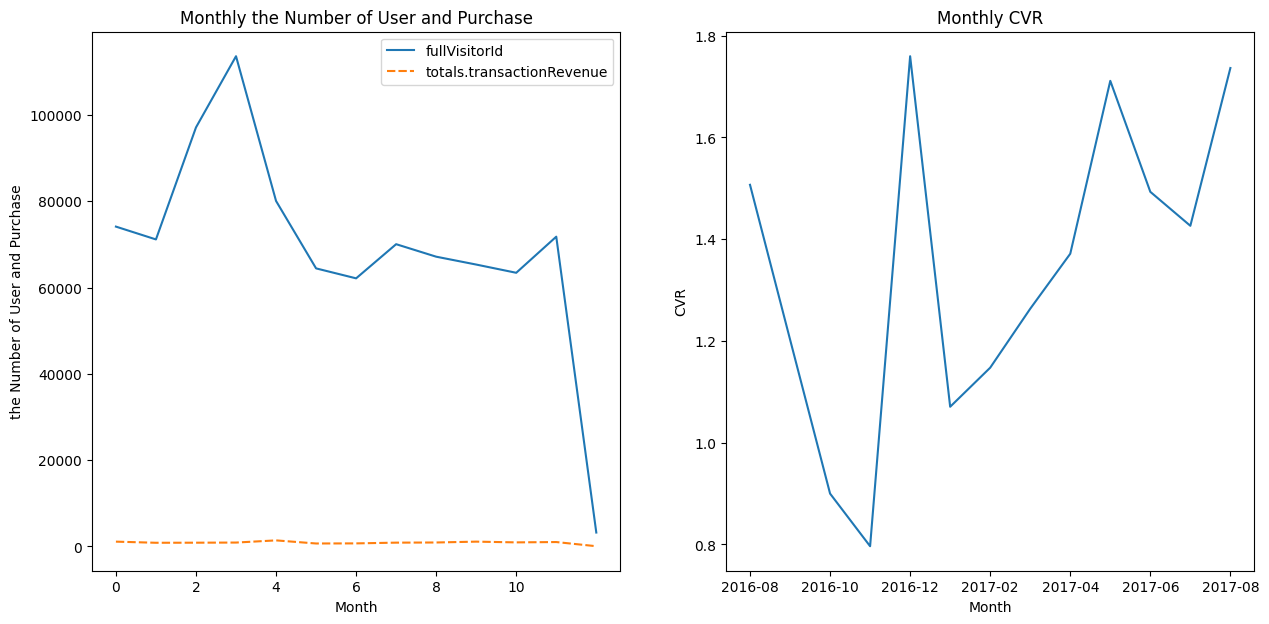

In [ ]:
plt.figure(figsize= (15,7))
plt.subplot(1, 2, 1)
sns.lineplot(data=cnt_by_month)
plt.title('Monthly the Number of User and Purchase')
plt.xticks(range(0, 12, 2))
plt.xlabel('Month')
plt.ylabel('the Number of User and Purchase')

plt.subplot(1, 2, 2)
sns.lineplot(data=cvr_by_month)
plt.xticks(range(0, 13, 2))
plt.title('Monthly CVR')
plt.xlabel('Month')
plt.ylabel('CVR')
plt.show()

# 좌측 그래프 보조축 넣어서 표현 가능할지 확인 필요 

Text(0.5, 1.0, 'total user count by week')

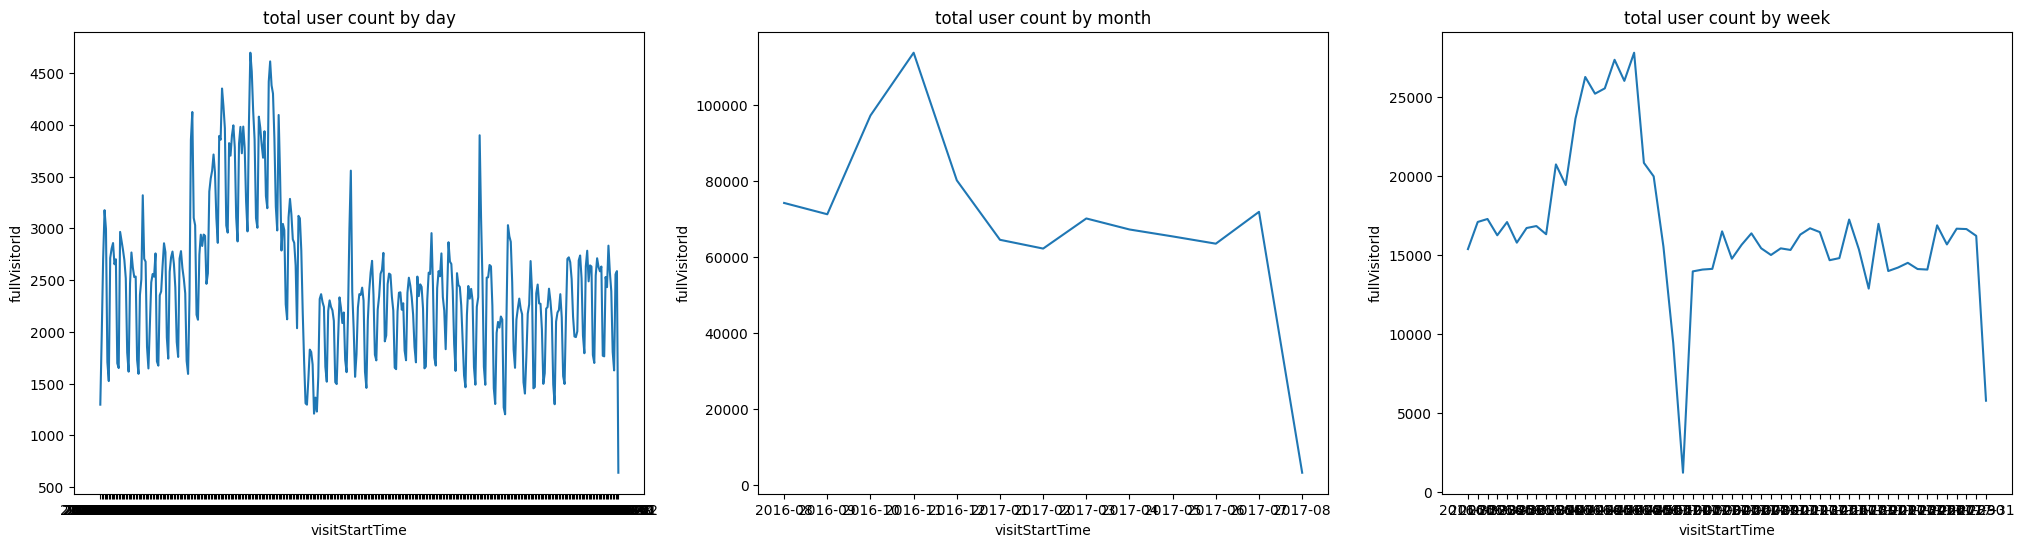

In [ ]:
dau_by_date = df.groupby(visit_ymd)['fullVisitorId'].count()
mau_by_date = df.groupby(visit_ym)['fullVisitorId'].count()
wau_by_date = df.groupby(visit_week)['fullVisitorId'].count()

plt.figure(figsize= (25,6))
plt.subplot(1, 3, 1)
sns.lineplot(data=dau_by_date)
plt.title('total user count by day')
plt.subplot(1, 3, 2)
sns.lineplot(data=mau_by_date)
plt.title('total user count by month')
plt.subplot(1, 3, 3)
sns.lineplot(data=wau_by_date)
plt.title('total user count by week')

,channelGrouping,fullVisitorId,totals.transactionRevenue,cvr
0,(Other),120,1,0.01
1,Affiliates,16403,9,0.00
2,Direct,143026,2042,0.01
3,Display,6262,142,0.02
4,Organic Search,381561,3438,0.01
5,Paid Search,25326,468,0.02
6,Referral,104838,5311,0.05
7,Social,226117,104,0.00


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, '(Other)'),
  Text(1, 0, 'Affiliates'),
  Text(2, 0, 'Direct'),
  Text(3, 0, 'Display'),
  Text(4, 0, 'Organic Search'),
  Text(5, 0, 'Paid Search'),
  Text(6, 0, 'Referral'),
  Text(7, 0, 'Social')])

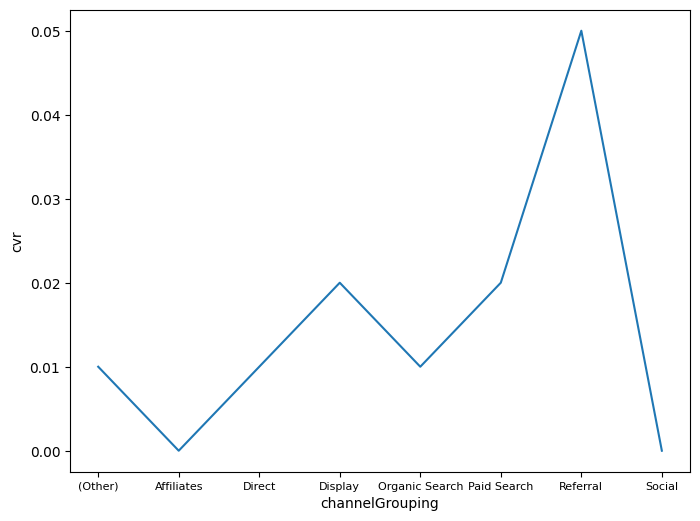

In [ ]:
# 채널별 월별 유저수 / 구매수 추이
pd.DataFrame(df.groupby(['channelGrouping', visit_ym])['fullVisitorId'].count()).unstack()
pd.DataFrame(df.groupby(['channelGrouping', visit_ym])['totals.transactionRevenue'].count()).unstack()

# 채널별 전환율
channel = df.groupby('channelGrouping')[['fullVisitorId','totals.transactionRevenue']].count().reset_index()
channel['cvr'] = (channel['totals.transactionRevenue'] / channel['fullVisitorId']).round(2)
display(channel)

plt.figure(figsize= (8,6))
sns.lineplot(x = channel['channelGrouping'], y = channel['cvr'])
plt.xticks(fontsize=8)

In [25]:
number_of_unique_user = df['fullVisitorId'].nunique()
number_of_revisit_user = (df['fullVisitorId'].value_counts() > 1).sum()

# 재방문 유저는 13% 
number_of_revisit_user / number_of_unique_user 


0.12958416791738037

평균체류시간 및 접속 시간대
- 유저별 평균접속시간의 분포를 ECDF(경험적 누적 분포 함수)로 시각화
    - https://lazymodellingcrew.com/post/post_14_reading_like_a_fourthgrader_ta/
- 요일/시간대별 사용자 수를 구하고 이를 heatmap으로 시각화

In [ ]:
# 세션 만료 기준 1) 방문자 활동이 없을 경우 30분 후 2) 자정

# 첫 접속과 마지막 접속 사이의 길이가 30분 이상의 차이가 나지 않을 때, 두 이벤트를 같은 세션으로 간주하는 전처리를 진행
# 이 경우 시간을 기준으로 sorting한 뒤, diff가 30분 이하인지 체크하고 cumsum해주면 id가 부여 (임의로 session_id 부여하는 방법)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 23 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   channelGrouping                               903653 non-null  object        
 1   date                                          903653 non-null  datetime64[ns]
 2   fullVisitorId                                 903653 non-null  object        
 3   visitNumber                                   903653 non-null  object        
 4   visitStartTime                                903653 non-null  datetime64[ns]
 5   device.isMobile                               903653 non-null  bool          
 6   device.deviceCategory                         903653 non-null  object        
 7   geoNetwork.continent                          903653 non-null  object        
 8   geoNetwork.country                            903653 n

세션 ID 생성

In [ ]:
# 시간, 방문자id 기준으로 정렬한 데이터 프레임 생성
df_sorted = df[['visitStartTime', 'fullVisitorId']]
df_sorted = df_sorted.sort_values(by=['visitStartTime', 'fullVisitorId'])
df_sorted['visit_ymd'] = df_sorted['visitStartTime'].dt.strftime('%Y-%m-%d')

# 유저별로 그룹핑하여 방문시간 차이가 30분 이상인 경우 신규 값 지정  
# 동일 일자 방문시간이 30분 이내에 3번 이상 방문한 경우 동일한 세션id가 부여되지 않음 
# df_sorted['session_cum_id'] = (df_sorted.groupby(['fullVisitorId','visit_ymd'])['visitStartTime'].diff(axis=0, periods=1) >= dt.timedelta(minutes=30)).transform('cumsum')


## sessoin_id 생성하기 
#유저id - 일별로 세션 시작시간 차이 계산 후 diff열 생성 
df_sorted['diff'] = df_sorted.groupby(['fullVisitorId', 'visit_ymd'])['visitStartTime'].diff()


# 개별 sessoin_id 부여할 조건절 변수 지정 
diff_cond = (df_sorted['diff'].isnull()) | (df_sorted['diff'] > dt.timedelta(minutes=30))
# 조건이 true면, cumsum을, 아니면 null을 출력
df_sorted['new_id'] = np.where(diff_cond, diff_cond.cumsum(), None)
# 데이터프레임을 id 기준으로 재정렬 
df_sorted = df_sorted.sort_values(by='fullVisitorId')    
# diff_cond 조건에 맞지 않아 null 처리된 열은 위 행과 동일한 id 값 부여 
df_sorted['new_id'] = df_sorted['new_id'].fillna(method='ffill') 


# 잘 들어갔는지 확인 
df_sorted.head(10)
df_sorted[df_sorted['fullVisitorId'].str.contains('358027242270102')]


,visitStartTime,fullVisitorId,visit_ymd,diff,new_id
363659,2016-12-24 07:01:06,358027242270102,2016-12-24,NaT,419508
363564,2016-12-24 07:05:51,358027242270102,2016-12-24,0 days 00:04:45,419508
363976,2016-12-24 07:06:14,358027242270102,2016-12-24,0 days 00:00:23,419508


유저별-세션ID별 평균 세션 시간

In [ ]:
# 세션 시간 구하기 
# 유저별-세션별로 max time 생성
df_sorted['max_time'] = df_sorted.groupby(['fullVisitorId','new_id'])['visitStartTime'].transform('max')

# max time에서 각 세션 시작시간 뺀 값 구하기 (체류 시간)
df_sorted['max_minus'] = df_sorted['max_time'] - df_sorted['visitStartTime']
df_sorted['max_minus'] = df_sorted['max_minus'].dt.seconds
# df_sorted['session_minutes'] = df_sorted['max_minus'] / 60
# df_sorted

In [ ]:
# 유저별 평균 체류 시간 구하기
# 동일한 세션id 내에서 max값 출력 
# 0포함 버전 
df_stay_time = pd.DataFrame(df_sorted.groupby(['fullVisitorId','new_id'])['max_minus'].max())
df_avg_stay_time = pd.DataFrame(df_stay_time.groupby('fullVisitorId')['max_minus'].mean())

# 0제외 버전 
df_stay_time_not_zero = df_stay_time[df_stay_time['max_minus'] > 0]
df_avg_stay_time_not_zero = pd.DataFrame(df_stay_time_not_zero.groupby('fullVisitorId')['max_minus'].mean())

df_avg_stay_time

,max_minus
fullVisitorId,
0000168159078983594,0.0
0000174067426171406,0.0
0000197671390269035,0.0
0000245437374675368,0.0
000026722803385797,0.0
...,...
9999963186378918199,0.0
999997225970956660,0.0
999997550040396460,0.0


<Axes: xlabel='max_minus', ylabel='Proportion'>

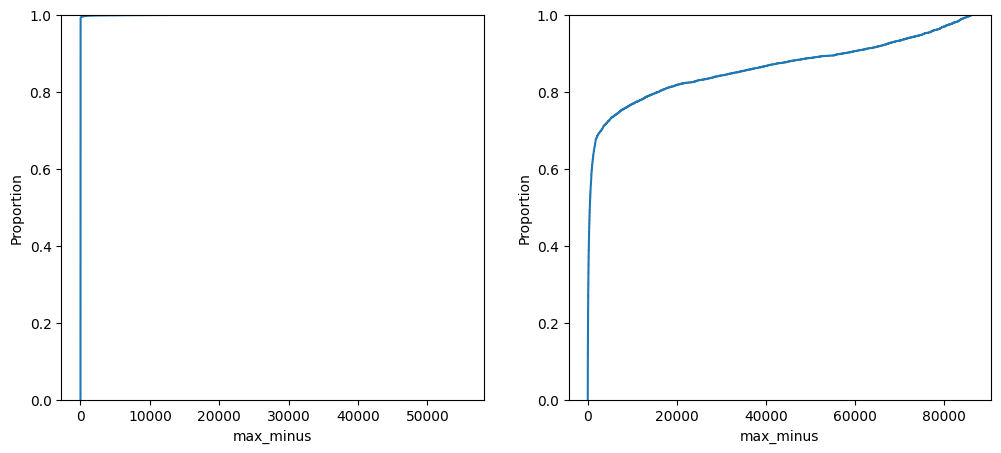

In [ ]:
#ECDF 그래프 시각화
plt.figure(figsize= (12,5))
plt.subplot(1,2,1)
sns.ecdfplot(data=df_avg_stay_time, x='max_minus')
plt.subplot(1,2,2)
sns.ecdfplot(data=df_avg_stay_time_not_zero, x='max_minus')

C:\Users\dkf22\AppData\Local\Temp\ipykernel_10652\1871627243.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session_time.loc[len(df_session_time)] = ['etc', small_total]


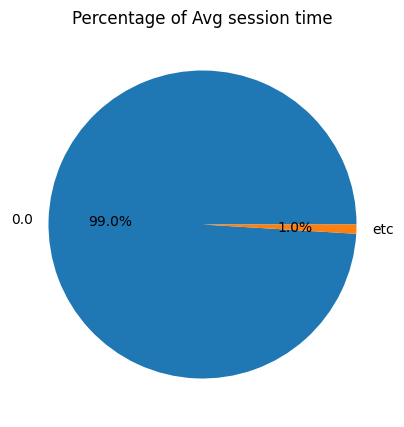

In [ ]:
## 평균 세션시간(/s)별 비중 구하기 

# 0인 경우가 99%
each_value = df_avg_stay_time.value_counts()
total_sum = df_avg_stay_time.value_counts().sum()
total_pct = each_value / total_sum

df_session_time_pct = total_pct.reset_index()
df_session_time_pct.columns = ['avg_session_time', 'percentage']
df_session_time_pct

# 0.01% 이하인 항목을 모두 합치기
threshold = 0.0001
small_values = df_session_time_pct[df_session_time_pct['percentage'] <= threshold]
small_total = small_values['percentage'].sum()
df_session_time = df_session_time_pct[df_session_time_pct['percentage'] > threshold]
df_session_time.loc[len(df_session_time)] = ['etc', small_total]
df_session_time

# 파이 그래프 그리기 
plt.figure(figsize=(5, 5))
plt.pie(df_session_time['percentage'], labels=df_session_time['avg_session_time'], autopct='%1.1f%%')
plt.title('Percentage of Avg session time')
plt.show()

유저별 일별 평균 세션시간 (마지막 세션시간-최초 세션시간 / 총 세션수) 

In [ ]:
# 평균 세션 시간 구하기 
# 유저별-일별로 max,mim time & total session count 생성
df_sorted['daily_max_time'] = df_sorted.groupby(['fullVisitorId','visit_ymd'])['visitStartTime'].transform('max')
df_sorted['daily_min_time'] = df_sorted.groupby(['fullVisitorId','visit_ymd'])['visitStartTime'].transform('min')
df_sorted['daily_total_seesion'] = df_sorted.groupby(['fullVisitorId','visit_ymd'])['new_id'].transform('nunique')

# 유저별 일별 세션 시간
# max time - min time / total session 으로 일 평균 세션 시간 구하기
df_sorted['daily_session_time'] = (df_sorted['daily_max_time']-df_sorted['daily_min_time']) 
df_sorted['daily_avg_session_time'] = (df_sorted['daily_max_time']-df_sorted['daily_min_time']) / df_sorted['daily_total_seesion']

df_sorted['daily_avg_session_time'] = df_sorted['daily_avg_session_time'].dt.seconds / 60
df_sorted['daily_avg_session_time'].describe()

count    903653.000000
mean         14.857992
std          61.327727
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         716.983333
Name: daily_avg_session_time, dtype: float64

<Axes: xlabel='daily_avg_session_time', ylabel='Proportion'>

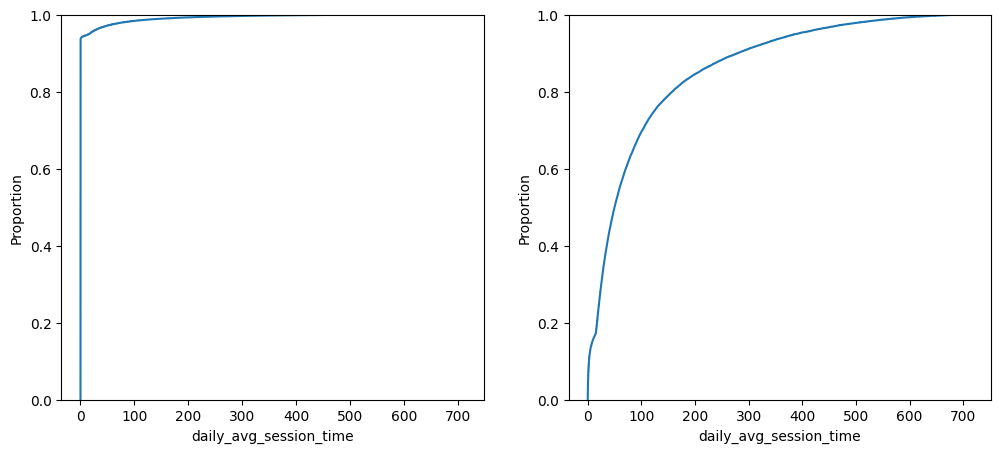

In [ ]:
# 유저별 일별 평균 세션 시간
# 0포함 버전 
df_avg_session_time = pd.DataFrame(df_sorted.groupby('fullVisitorId')['daily_avg_session_time'].mean())

# 0제외 버전 
df_session_time_not_zero = df_sorted[df_sorted['daily_avg_session_time'] > 0]
df_avg_session_time_not_zero = pd.DataFrame(df_session_time_not_zero.groupby('fullVisitorId')['daily_avg_session_time'].mean())

#ECDF 그래프 시각화
plt.figure(figsize= (12,5))
plt.subplot(1,2,1)
sns.ecdfplot(data=df_avg_session_time, x='daily_avg_session_time')
plt.subplot(1,2,2)
sns.ecdfplot(data=df_avg_session_time_not_zero, x='daily_avg_session_time')


In [ ]:
df_session_time_not_zero.describe()
df_session_time_not_zero['daily_avg_session_time'].describe()

count    123276.000000
mean        108.913895
std         131.628733
min           0.016667
25%          23.583333
50%          57.266667
75%         137.833333
max         716.983333
Name: daily_avg_session_time, dtype: float64

In [ ]:
## 세션이 0초 초과 발생했던 유저 ID중에서 구매 전환을 발생한 비율 
con_by_user = pd.DataFrame(df.groupby('fullVisitorId')['Revenue_yn'].sum()).reset_index()
revenue_cond = con_by_user['Revenue_yn'] > 0
# 구매를 발생한 유저id만 발라내기 
con_by_user[revenue_cond]

# 세션 0초과하는 유저id 
not_zero_session = pd.DataFrame(df_session_time_not_zero['fullVisitorId'].value_counts()).reset_index()
not_zero_session


salesnsession_by_user = pd.merge(con_by_user[revenue_cond], not_zero_session, how='left', on='fullVisitorId')
salesnsession_by_user['count'].count() / salesnsession_by_user['Revenue_yn'].count()

not_zero_session.count()
con_by_user[revenue_cond].count()

10030 / 46895

0.21388207698048833

In [ ]:
## 평균 체류시간(/s)별 비중 구하기 

# 0인 경우가 99%
each_session_time = df_avg_session_time.value_counts()
sum_session_time = df_avg_session_time.value_counts().sum()
pct_session_time = each_session_time / sum_session_time

df_pct_session_time = pct_session_time.reset_index()
df_pct_session_time.columns = ['avg_session_time', 'percentage']
df_pct_session_time


# 0.01% 이하인 항목을 모두 합치기
threshold = 0.0002
etc_values = df_pct_session_time[df_pct_session_time['percentage'] < threshold]
etc_total = etc_values['percentage'].sum()
df_pct_session = df_pct_session_time[df_pct_session_time['percentage'] >= threshold]
df_pct_session.loc[len(df_pct_session)] = ['etc', etc_total]
df_pct_session


C:\Users\dkf22\AppData\Local\Temp\ipykernel_10504\1895367939.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pct_session.loc[len(df_pct_session)] = ['etc', etc_total]


,avg_session_time,percentage
0,0.0,0.934589
1,etc,0.065411


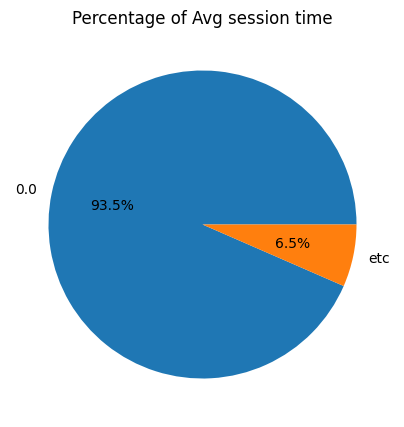

In [ ]:
# 파이 그래프 그리기 
plt.figure(figsize=(5, 5))
plt.pie(df_pct_session['percentage'], labels=df_pct_session['avg_session_time'], autopct='%1.1f%%')
plt.title('Percentage of Avg session time')
plt.show()

이탈률 
- 페이지뷰1 & 히트1인 유저 = 이탈로 간주
- 월별 이탈률 비교?

In [24]:
# 추후 검토

요일-시간대별 방문자수 히트맵

([<matplotlib.axis.XTick at 0x1696ffa61f0>,
 [Text(0, 0, 'Mon'),
  Text(1, 0, 'Tue'),
  Text(2, 0, 'Wed'),
  Text(3, 0, 'Thu'),
  Text(4, 0, 'Fri'),
  Text(5, 0, 'Sat'),
  Text(6, 0, 'Sun')])

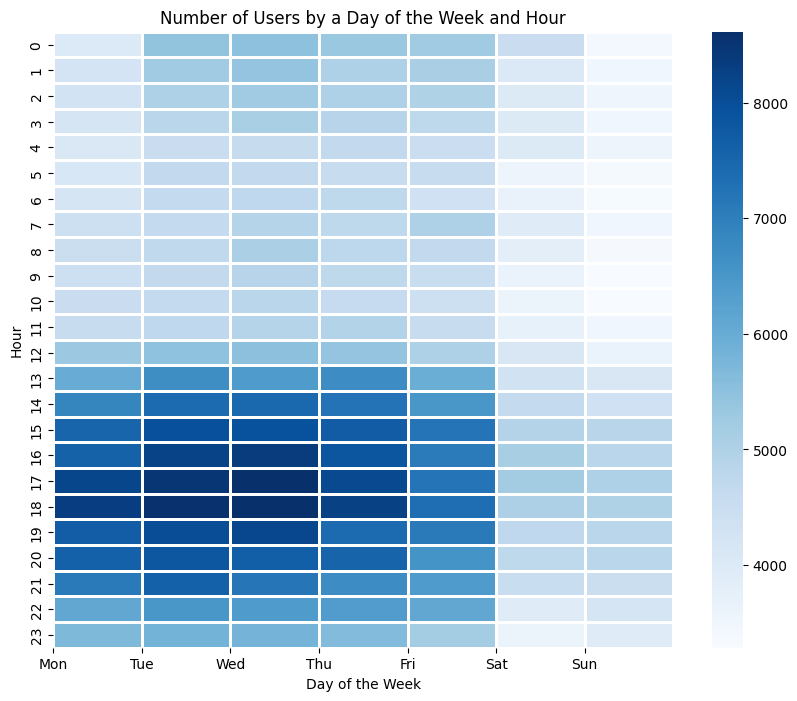

In [ ]:
#시간으로 변환
visit_hour = df['visitStartTime'].dt.hour

# 피봇테이블 생성
# 행 index는 시간, 열 columns 는 요일, 사용할 값은 유저수
wod_hour_pivot = pd.pivot_table(df, index=visit_hour, columns=visit_dayofweek, values=['fullVisitorId'], aggfunc = 'count')

#요일-시간대 히트맵 생성 
plt.figure(figsize=(10, 8))
sns.heatmap(wod_hour_pivot, cmap='Blues', annot=False, linewidths=2)
plt.title('Number of Users by a Day of the Week and Hour')
plt.xlabel('Day of the Week')
plt.ylabel('Hour')
plt.xticks(range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

요일-시간대별 구매자수 히트맵

In [ ]:
df_purchase = df[df['totals.transactionRevenue'].notnull()]

purchase_hour = df_purchase['visitStartTime'].dt.hour
purchase_dayofweek = df_purchase['visitStartTime'].dt.weekday # 월요일이 0 

([<matplotlib.axis.XTick at 0x1697bb7e280>,
 [Text(0, 0, 'Mon'),
  Text(1, 0, 'Tue'),
  Text(2, 0, 'Wed'),
  Text(3, 0, 'Thu'),
  Text(4, 0, 'Fri'),
  Text(5, 0, 'Sat'),
  Text(6, 0, 'Sun')])

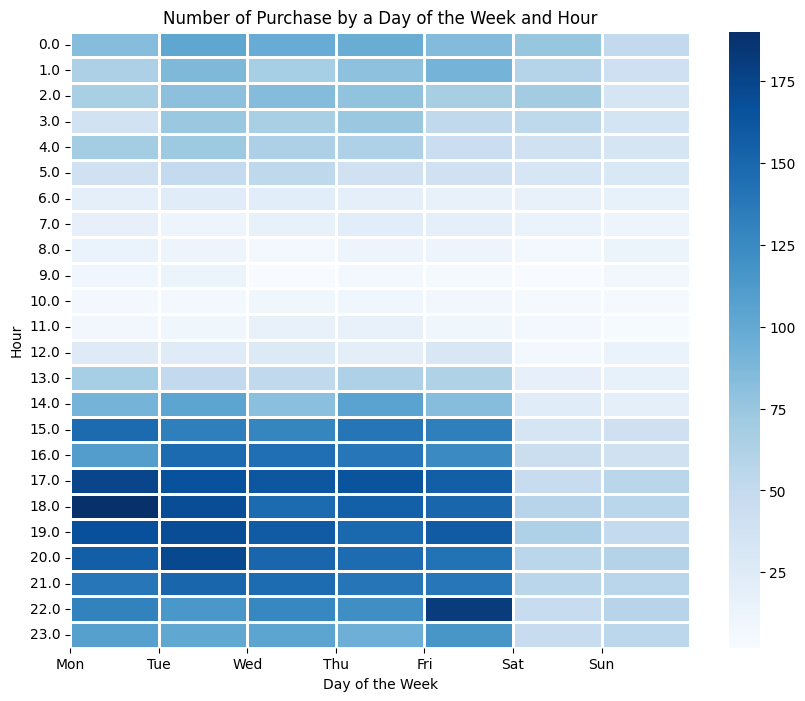

In [ ]:
# 피봇테이블 생성
# 행 index는 시간, 열 columns 는 요일, 사용할 값은 유저수
purchase_wod_hour_pivot = pd.pivot_table(df, index=purchase_hour, columns=purchase_dayofweek, values=['fullVisitorId'], aggfunc = 'count')

#요일-시간대 히트맵 생성 
plt.figure(figsize=(10, 8))
sns.heatmap(purchase_wod_hour_pivot, cmap='Blues', annot=False, linewidths=2)
plt.title('Number of Purchase by a Day of the Week and Hour')
plt.xlabel('Day of the Week')
plt.ylabel('Hour')
plt.xticks(range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

### 모델링 및 평가 함수 생성

In [23]:
def get_score(train:pd.DataFrame,  test:pd.DataFrame, x_var_list:list):
    """ train과 test 데이터와 X변수 컬럼을 받아 평가지표를 내는 함수입니다.

    Args:
        train (pd.DataFrame): train 데이터프레임
        test (pd.DataFrame): test 데이터프레임
        x_var_list (list): 모델링에 사용할 변수 리스트
    """
    #외부 전달인자를 내부변수에 할당
    X_train = train 
    X_test = test

    #일부 컬럼만 가져오기
    X_train = X_train[x_var_list]
    X_test = X_test[x_var_list]
    
    #모듈불러오기
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBRFClassifier
    from sklearn.metrics import accuracy_score, f1_score
        
    #모델 가져오기
    model_log = LogisticRegression()
    model_dt = DecisionTreeClassifier(random_state=42)
    model_rf = RandomForestClassifier(random_state=42)
    model_xgb = XGBRFClassifier(random_state=42)

    #모델 학습하기
    model_log.fit(X_train, y_train)
    model_dt.fit(X_train, y_train)
    model_rf.fit(X_train, y_train)
    model_xgb.fit(X_train, y_train)
    
    # 학습하여 결과 저장
    y_pred_log_train = model_log.predict(X_train)
    y_pred_log_test = model_log.predict(X_test)

    y_pred_dt_train = model_dt.predict(X_train)
    y_pred_dt_test = model_dt.predict(X_test)

    y_pred_rf_train = model_rf.predict(X_train)
    y_pred_rf_test = model_rf.predict(X_test)

    y_pred_xgb_train = model_xgb.predict(X_train)
    y_pred_xgb_test = model_xgb.predict(X_test)

    #평가표 생성
    result = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_log_train), accuracy_score(y_train, y_pred_dt_train), accuracy_score(y_train, y_pred_rf_train), accuracy_score(y_train, y_pred_xgb_train), 
                                    accuracy_score(y_test, y_pred_log_test),accuracy_score(y_test, y_pred_dt_test),accuracy_score(y_test, y_pred_rf_test),accuracy_score(y_test, y_pred_xgb_test)],
                            'f1_score' : [f1_score(y_train, y_pred_log_train),f1_score(y_train, y_pred_dt_train),f1_score(y_train, y_pred_rf_train),f1_score(y_train, y_pred_xgb_train), 
                                          f1_score(y_test, y_pred_log_test), f1_score(y_test, y_pred_dt_test), f1_score(y_test, y_pred_rf_test), f1_score(y_test, y_pred_xgb_test)]},
                            index=pd.MultiIndex.from_tuples([('train', 'logistic'),('train', 'dt'), ('train', 'rf'), ('train', 'XGB'),
                                                             ('test', 'logistic'),('test', 'dt'), ('test', 'rf'), ('test', 'XGB')]))
    

    display(result.round(2))

# duration 변수만 사용하여 결과내기
get_score(X_train, X_test, ['channel_en','deviceCategory_en','continent_en','campaign_yn','newVisits_yn'])

c:\Users\dkf22\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\dkf22\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


acc  f1_score
train logistic  0.99       0.0
      dt        0.99       0.0
      rf        0.99       0.0
      XGB       0.99       0.0
test  logistic  0.99       0.0
      dt        0.99       0.0
      rf        0.99       0.0
      XGB       0.99       0.0